<a href="https://colab.research.google.com/github/rittikarijhwani/movie-recommendation-system/blob/main/movie_rec_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Sequential
from pathlib import Path
import matplotlib.pyplot as plt
import pickle

In [ ]:
# First, load the data and apply preprocessing

# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-latest-small.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-latest-small"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.csv"
df = pd.read_csv(ratings_file)


978202/978202 [==============================] - 0s 0us/step
Extracting all the files now...
Done!


In [ ]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
#extracts ids and converts it into a list, encodes id to index in list for user and movies
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
#adds encoded index columns to df
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

In [ ]:
movie2movie_encoded

{1: 0,
 3: 1,
 6: 2,
 47: 3,
 50: 4,
 70: 5,
 101: 6,
 110: 7,
 151: 8,
 157: 9,
 163: 10,
 216: 11,
 223: 12,
 231: 13,
 235: 14,
 260: 15,
 296: 16,
 316: 17,
 333: 18,
 349: 19,
 356: 20,
 362: 21,
 367: 22,
 423: 23,
 441: 24,
 457: 25,
 480: 26,
 500: 27,
 527: 28,
 543: 29,
 552: 30,
 553: 31,
 590: 32,
 592: 33,
 593: 34,
 596: 35,
 608: 36,
 648: 37,
 661: 38,
 673: 39,
 733: 40,
 736: 41,
 780: 42,
 804: 43,
 919: 44,
 923: 45,
 940: 46,
 943: 47,
 954: 48,
 1009: 49,
 1023: 50,
 1024: 51,
 1025: 52,
 1029: 53,
 1030: 54,
 1031: 55,
 1032: 56,
 1042: 57,
 1049: 58,
 1060: 59,
 1073: 60,
 1080: 61,
 1089: 62,
 1090: 63,
 1092: 64,
 1097: 65,
 1127: 66,
 1136: 67,
 1196: 68,
 1197: 69,
 1198: 70,
 1206: 71,
 1208: 72,
 1210: 73,
 1213: 74,
 1214: 75,
 1219: 76,
 1220: 77,
 1222: 78,
 1224: 79,
 1226: 80,
 1240: 81,
 1256: 82,
 1258: 83,
 1265: 84,
 1270: 85,
 1275: 86,
 1278: 87,
 1282: 88,
 1291: 89,
 1298: 90,
 1348: 91,
 1377: 92,
 1396: 93,
 1408: 94,
 1445: 95,
 1473: 96,
 

In [ ]:
df.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4


In [ ]:
num_users = len(user2user_encoded)
num_movies = len(movie2movie_encoded)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating))


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [ ]:
#Random Train-Test split
df = df.sample(frac=1, random_state=42) # randomly shuffles dataset to ensure that model does not learn patterns specific to the data order
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [ ]:
x_train.shape

(90752, 2)

In [ ]:
y_train.shape

(90752,)

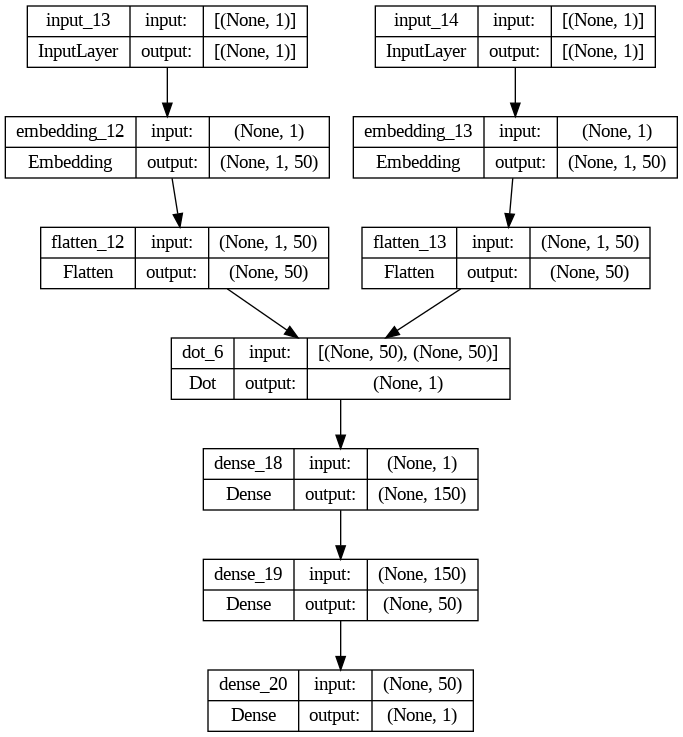

In [ ]:
#defining the model
embedding_size = 50

#vectors capture the underlying preferences of users and the characteristics of movies.
user_ips= layers.Input(shape=[1])
user_embedding = layers.Embedding(num_users,embedding_size)(user_ips)
# Embedding layer will create 610 vectors look-up table of 50 dimension each
user_vect= layers.Flatten()(user_embedding)

movie_ips= layers.Input(shape=[1])
movie_embedding = layers.Embedding(num_movies, embedding_size)(movie_ips)
movie_vect= layers.Flatten()(movie_embedding)

#calculates the dot product
prod = layers.dot(inputs=[user_vect, movie_vect],axes=1)

dense1= layers.Dense(150, activation='relu')(prod)
dense2= layers.Dense(50, activation='relu')(dense1)
dense3= layers.Dense(1,activation='relu')(dense2)

#compiling model
model = Model([user_ips, movie_ips], dense3)
model.compile(optimizer='adam',loss='mean_squared_error')

#creating model diagram
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
history = model.fit([x_train[:,0], x_train[:,1]], y_train, batch_size=64,epochs=10,verbose=1)

Epoch 1/10
1418/1418 [==============================] - 9s 6ms/step - loss: 0.0530
Epoch 2/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.0237
Epoch 3/10
1418/1418 [==============================] - 5s 4ms/step - loss: 0.0122
Epoch 4/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.0084
Epoch 5/10
1418/1418 [==============================] - 5s 4ms/step - loss: 0.0070
Epoch 6/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.0060
Epoch 7/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.0052
Epoch 8/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.0046
Epoch 9/10
1418/1418 [==============================] - 5s 4ms/step - loss: 0.0041
Epoch 10/10
1418/1418 [==============================] - 6s 4ms/step - loss: 0.0037


In [ ]:
pred=model.predict([x_train[4:5,0], x_train[4:5,1]])
pred

1/1 [==============================] - 0s 98ms/step


array([[0.78819484]], dtype=float32)

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.csv")
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[ ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]

In [ ]:
user_id

246

In [ ]:
movies_watched_by_user.head()

,userId,movieId,rating,timestamp,user,movie
36078,246,7361,5.0,1354125086,245,1129
36082,246,7669,5.0,1354126091,245,3598
36150,246,82202,4.0,1355956402,245,1934
36103,246,41569,3.0,1354145727,245,2299
36129,246,65261,5.0,1354134450,245,5264


In [ ]:
movies_not_watched

0            1
1            2
2            3
3            4
4            5
         ...  
9737    193581
9738    193583
9739    193585
9740    193587
9741    193609
Name: movieId, Length: 9538, dtype: int64

In [ ]:
## basically inner join between movies_not_watched and movie ids from df table (to be sure that the movie ids are not out of scope)
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 131098,
 30,
 31,
 32,
 32799,
 34,
 131104,
 36,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 65577,
 65585,
 52,
 53,
 54,
 55,
 65588,
 57,
 58,
 98361,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 65596,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 85,
 86,
 87,
 88,
 89,
 163925,
 92,
 93,
 94,
 95,
 96,
 97,
 32862,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 32875,
 110,
 111,
 112,
 113,
 65642,
 65651,
 116,
 117,
 118,
 119,
 121,
 122,
 32892,
 125,
 126,
 128,
 129,
 32898,
 132,
 135,
 137,
 32906,
 140,
 141,
 163981,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 164,
 165,
 166,
 131237,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 9

In [ ]:
movies_not_watched_index = [[movie2movie_encoded.get(x)] for x in movies_not_watched]  # get the indexes of the movies not watched by the user
movies_not_watched_index

[[0],
 [481],
 [1],
 [482],
 [483],
 [2],
 [484],
 [485],
 [5017],
 [486],
 [487],
 [1399],
 [488],
 [3678],
 [489],
 [490],
 [2657],
 [492],
 [3604],
 [291],
 [493],
 [2163],
 [494],
 [495],
 [496],
 [497],
 [3938],
 [6914],
 [259],
 [292],
 [8955],
 [460],
 [3939],
 [461],
 [1859],
 [462],
 [6704],
 [498],
 [5992],
 [499],
 [971],
 [293],
 [500],
 [3],
 [1400],
 [5596],
 [4192],
 [4529],
 [294],
 [3711],
 [501],
 [3679],
 [3811],
 [2651],
 [295],
 [3635],
 [502],
 [503],
 [504],
 [5832],
 [1401],
 [505],
 [506],
 [1290],
 [4035],
 [2663],
 [5],
 [4663],
 [5550],
 [4698],
 [2420],
 [5018],
 [507],
 [9348],
 [2421],
 [508],
 [6915],
 [4036],
 [2503],
 [5687],
 [4037],
 [509],
 [510],
 [511],
 [512],
 [4432],
 [513],
 [514],
 [2431],
 [515],
 [8152],
 [5289],
 [9533],
 [5551],
 [516],
 [6],
 [517],
 [8579],
 [518],
 [519],
 [296],
 [1402],
 [9349],
 [2799],
 [7],
 [1093],
 [520],
 [521],
 [4765],
 [5643],
 [4038],
 [9411],
 [1403],
 [7421],
 [2504],
 [2543],
 [4309],
 [297],
 [298],
 [6

In [ ]:
user_encoder = user2user_encoded.get(user_id)
user_encoder

245

In [ ]:
user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched_index))
user_movie_array ## 1st column is user_index and 2nd col is the list of movie indexes not watched by the user

array([[ 245,    0],
       [ 245,  481],
       [ 245,    1],
       ...,
       [ 245, 3870],
       [ 245, 2989],
       [ 245, 7869]])

In [ ]:
ratings = model.predict([user_movie_array[:,0],user_movie_array[:,1]]).flatten()
ratings

298/298 [==============================] - 1s 2ms/step


array([0.8391459 , 0.83173555, 0.8583264 , ..., 0.7233966 , 0.8316346 ,
       0.6270495 ], dtype=float32)

In [ ]:
top_ratings_indices = ratings.argsort()[-10:][::-1] # indices of highest 10 ratings

In [ ]:
recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched_index[x][0]) for x in top_ratings_indices]

In [ ]:
print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 246
Movies with high ratings from user
--------------------------------
Others, The (2001) : Drama|Horror|Mystery|Thriller
Big Fish (2003) : Drama|Fantasy|Romance
Watchmen (2009) : Action|Drama|Mystery|Sci-Fi|Thriller|IMAX
Inglourious Basterds (2009) : Action|Drama|War
Princess and the Frog, The (2009) : Animation|Children|Fantasy|Musical|Romance


In [ ]:
print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


--------------------------------
Top 10 movie recommendations
--------------------------------
Bound (1996) : Crime|Drama|Romance|Thriller
Full Metal Jacket (1987) : Drama|War
Ben-Hur (1959) : Action|Adventure|Drama
Waiting for Guffman (1996) : Comedy
Mummy, The (1999) : Action|Adventure|Comedy|Fantasy|Horror|Thriller
Stir of Echoes (1999) : Horror|Mystery|Thriller
Fist of Legend (Jing wu ying xiong) (1994) : Action|Drama
Pursuit of Happyness, The (2006) : Drama
There Will Be Blood (2007) : Drama|Western
Hot Tub Time Machine (2010) : Comedy|Sci-Fi


In [ ]:
model.save(r'C:\Users\ritzr\PycharmProjects\movie-rec-system-mpr.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
